# Deconvolve
### Dependencies

In [1]:
import numpy as np
import healpy as hp
import fitsio
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
import camb
from camb.sources import SplinedSourceWindow

In [3]:
nside = 1024
lmax = 1000

In [4]:
pars = camb.CAMBparams()
pars.set_cosmology(H0=67., omch2=0.270*0.67**2, ombh2=0.049*0.67**2)
pars.InitPower.set_params(As=2.1e-9, ns=0.96)
pars.Want_CMB = False 
pars.NonLinear = camb.model.NonLinear_both
                  #lmax
pars.set_for_lmax(2*lmax, lens_potential_accuracy=1);

In [5]:
z = np.linspace(0, 3, 300)
nz = np.exp(-((0.3-z)/0.1)**2)
bz = 0.83070341 + 1.19054721*z - 0.92835749*z**2 + 0.42329232*z**3
sources = []
sources += [
    SplinedSourceWindow(source_type='counts', z=z, W=nz, bias_z=bz),
    SplinedSourceWindow(source_type='lensing', z=z, W=nz)]
pars.SourceWindows = sources

In [6]:
results = camb.get_results(pars)
# lmax= 2*lmax+1
theory_cls = results.get_source_cls_dict(lmax=2*lmax, raw_cl=True)

l = np.arange(lmax+1)
fl = -np.sqrt((l+2)*(l+1)*l*(l-1))
fl /= np.clip(l*(l+1), 1, None)

l = np.arange(2*lmax+1)
fl2 = -np.sqrt((l+2)*(l+1)*l*(l-1))
fl2 /= np.clip(l*(l+1), 1, None)

In [7]:
theory_cls['W2xW2'] = theory_cls['W2xW2'] * fl2**2
theory_cls['W1xW2'] = theory_cls['W1xW2'] * fl2

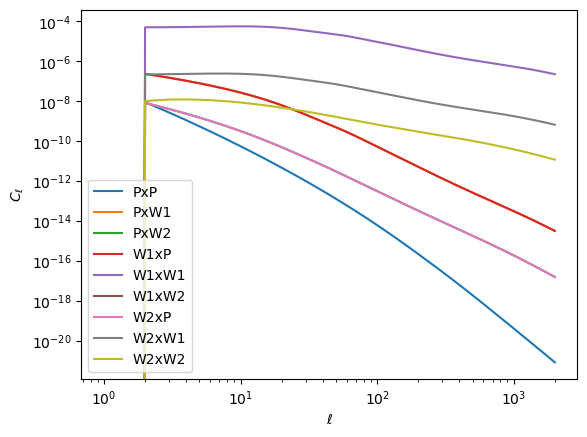

In [8]:
for key in list(theory_cls.keys()):
    plt.plot(theory_cls[key], label=key)
plt.legend()
plt.loglog()
plt.xlabel(r"$\ell$")
plt.ylabel(r"$C_\ell$")
plt.show()

In [9]:
theory_map = hp.sphtfunc.synfast([
    theory_cls['W1xW1'],
    theory_cls['W2xW2'],
    np.zeros(2*lmax+1),
    theory_cls['W1xW2']],
    nside, new=True)
theory_map.shape

(3, 12582912)

In [10]:
mask = np.ones_like(theory_map[1])
pixel_theta, pixel_phi = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)))

#Patch
#mask[np.pi/3 > pixel_theta] = 0.0
#mask[pixel_theta > 2*np.pi/3] = 0.0
#mask[pixel_phi > np.pi/2] = 0.0
#mask[np.pi/8> pixel_phi] = 0.0

# One third cover
#mask[2*np.pi/3 > pixel_theta] = 0.0

# Half cover
#mask[np.pi/2 > pixel_theta] = 0.0

# two thirds cover
#mask[np.pi/3 > pixel_theta] = 0.0

# Euclid North
vmap_n = hp.read_map('/home/jaimerz/Documents/UCL/heracles/data/vmap_wlfs2_dr1n_vis24.5_nomag.fits')
vmap_n[vmap_n == hp.UNSEEN] = 0.
vmap_n = hp.ud_grade(vmap_n, nside)
mask *= vmap_n
# Euclid South
#vmap_s = hp.read_map('/home/jaimerz/Documents/UCL/heracles/data/vmap_wlfs2_dr1s_vis24.5_nomag.fits')
#vmap_s[vmap_s == hp.UNSEEN] = 0.
#vmap_s = hp.ud_grade(vmap_s, nside)
#mask *= vmap_s

# Euclid combined
#vmap = vmap_n + vmap_s
#mask *= vmap

maps = {('P', 0): theory_map[0]*mask,
        ('G', 0): np.array([theory_map[1]*mask, theory_map[2]*mask], np.dtype(float, metadata={'spin': 2})),}

list(maps.keys())

[('P', 0), ('G', 0)]

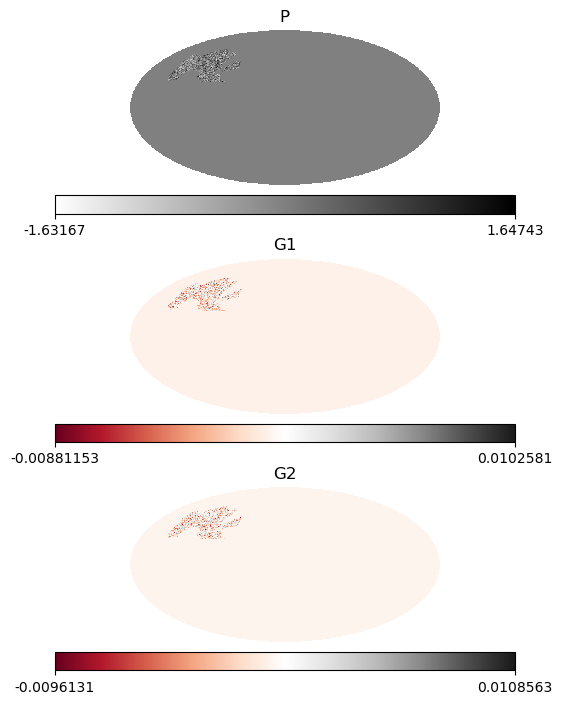

In [11]:
fig, ax = plt.subplots(3, figsize=(20, 7))
fig.tight_layout()
plt.sca(ax[0])
hp.mollview(maps[('P', 0)], cmap='binary', title='P', hold=True)
plt.sca(ax[1])
hp.mollview(maps[('G', 0)][0], cmap='RdGy', title='G1', hold=True)
plt.sca(ax[2])
hp.mollview(maps[('G', 0)][1], cmap='RdGy', title='G2', hold=True)
plt.show()

### Fields

In [12]:
from heracles.fields import Positions, Shears
from heracles.maps import Healpix

mapper = Healpix(nside, lmax)
fields = {
    "P": Positions(mapper, "RIGHT_ASCENSION", "DECLINATION", mask="V"),
    "G": Shears(mapper, "RIGHT_ASCENSION", "DECLINATION", "G1", "-G2", "WEIGHT", mask="W"),
}

### Alms

In [13]:
from heracles.maps import transform
alms = transform(fields, maps, progress=True)
list(alms.keys())

Output()

[('P', 0), ('G', 0)]

### Two-point statistics

In [14]:
from heracles.twopoint import angular_power_spectra, bin2pt
cls = angular_power_spectra(alms)
list(cls.keys())

[('P', 'P', 0, 0),
 ('P', 'G_E', 0, 0),
 ('P', 'G_B', 0, 0),
 ('G_E', 'G_E', 0, 0),
 ('G_E', 'G_B', 0, 0),
 ('G_B', 'G_B', 0, 0)]

In [15]:
cls[('P', 'P', 0, 0)].shape
np.zeros(2*lmax+1)

array([0., 0., 0., ..., 0., 0., 0.])

### Binning

In [16]:
bin_edges = np.linspace(0, lmax, 31).astype(int)
B = np.diag(np.ones(lmax+1))
B = bin2pt(B, bin_edges, 'B')
binned_ls = B['L']
B = B['B']

n, m = B.shape
B2 = np.zeros((n, 2*lmax+1))
B2[:, :lmax+1] = B

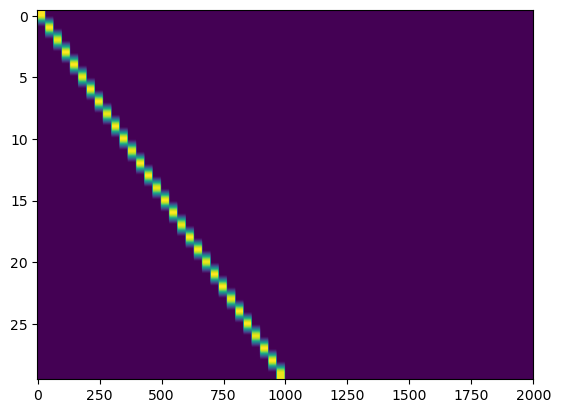

In [17]:
plt.imshow(B2, aspect='auto')

## Mixing Matrix

In [18]:
from heracles.fields import Visibility, Weights
from heracles.twopoint import mixing_matrices
from heracles.maps import map_catalogs

In [19]:
mapper_mm = Healpix(2*nside, 2*lmax)
fields = {"P": Positions(None, mask="V"),
          "G": Shears(None, "RIGHT_ASCENSION", "DECLINATION", "G1", "-G2", "WEIGHT", mask="W"),
          "V": Visibility(mapper_mm),
          "W": Weights(mapper_mm, "RIGHT_ASCENSION", "DECLINATION", "WEIGHT")}
masks = {("V", 0): mask,
         ("W", 0): mask}
mask_alms = transform(fields, masks, progress=True)
mask_cls = angular_power_spectra(mask_alms)
mms = mixing_matrices(fields, mask_cls,
    l3max=2*lmax+lmax, l2max=2*lmax, l1max=lmax, progress=True)

Output()

Output()

In [20]:
fields_a = np.unique([i[0] for i in mms.keys()])
fields_b = np.unique([i[1] for i in mms.keys()])
translator = {'P': 'W1', 'G_E': 'W2', 'G_B': 'W2'}

('G_B', 'G_B', 0, 0) W2xW2
('G_E', 'G_B', 0, 0) W2xW2
('G_E', 'G_E', 0, 0) W2xW2
('P', 'G_E', 0, 0) W1xW2
('P', 'P', 0, 0) W1xW1


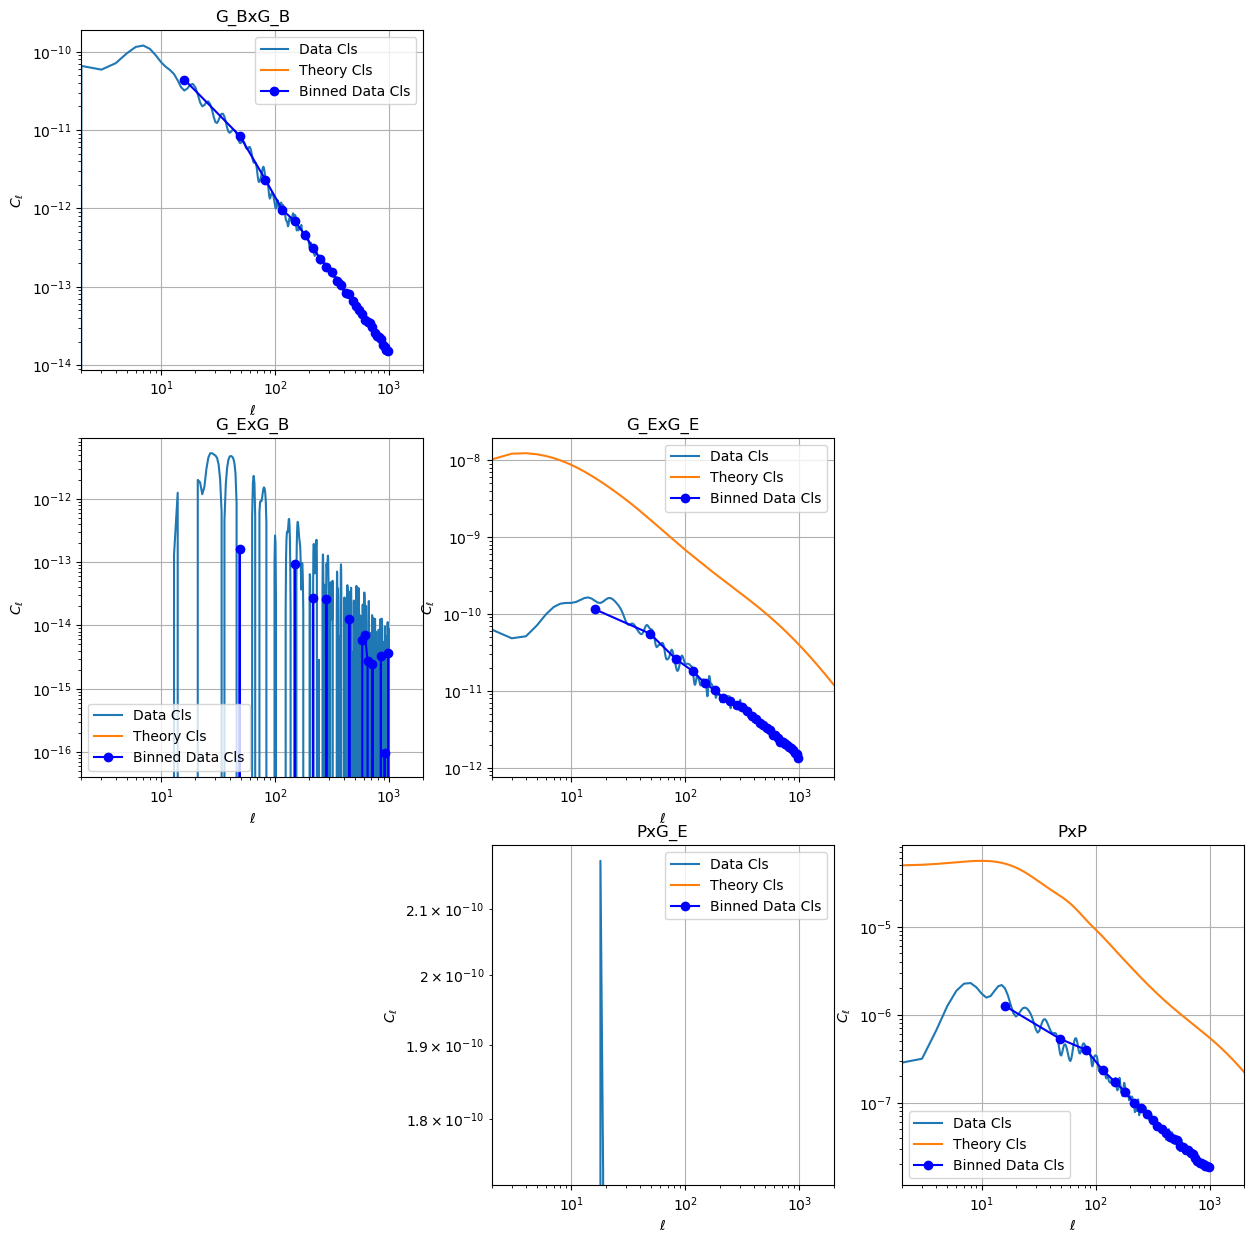

In [21]:
figure, axis = plt.subplots(3, 3, figsize=(5*3, 5*3))
for i, s1 in enumerate(fields_a):
    for j, s2 in enumerate(fields_b):
        proposed_key = (s1, s2, 0, 0)
        if proposed_key in list(mms.keys()):
            print(proposed_key, f"{translator[s1]}x{translator[s2]}") 
            if s1 == "G_B" or s2 == "G_B":
                t = np.zeros(2*lmax+1)
            else:
                t = theory_cls[f"{translator[s1]}x{translator[s2]}"]
            d = cls[proposed_key]

            axis[i, j].plot(d, label="Data Cls")
            axis[i, j].plot(t, label="Theory Cls")
            axis[i, j].plot(binned_ls, B@d, "bo-", label="Binned Data Cls")
            axis[i, j].set_xscale('log')
            axis[i, j].set_yscale('log')
            axis[i, j].set_title(f"{s1}x{s2}")
            axis[i, j].set_xlabel(r"$\ell$")
            axis[i, j].set_ylabel(r"$C_\ell$")
            axis[i, j].grid()
            axis[i, j].set_xlim(2, 2*lmax)
            axis[i, j].legend()
        else:
            axis[i, j].axis('off')
plt.show()

## Forward Model 

In [22]:
from heracles.core import TocDict

('G_B', 'G_B', 0, 0) W2xW2
('G_E', 'G_B', 0, 0) W2xW2
('G_E', 'G_E', 0, 0) W2xW2
('P', 'G_E', 0, 0) W1xW2
('P', 'P', 0, 0) W1xW1


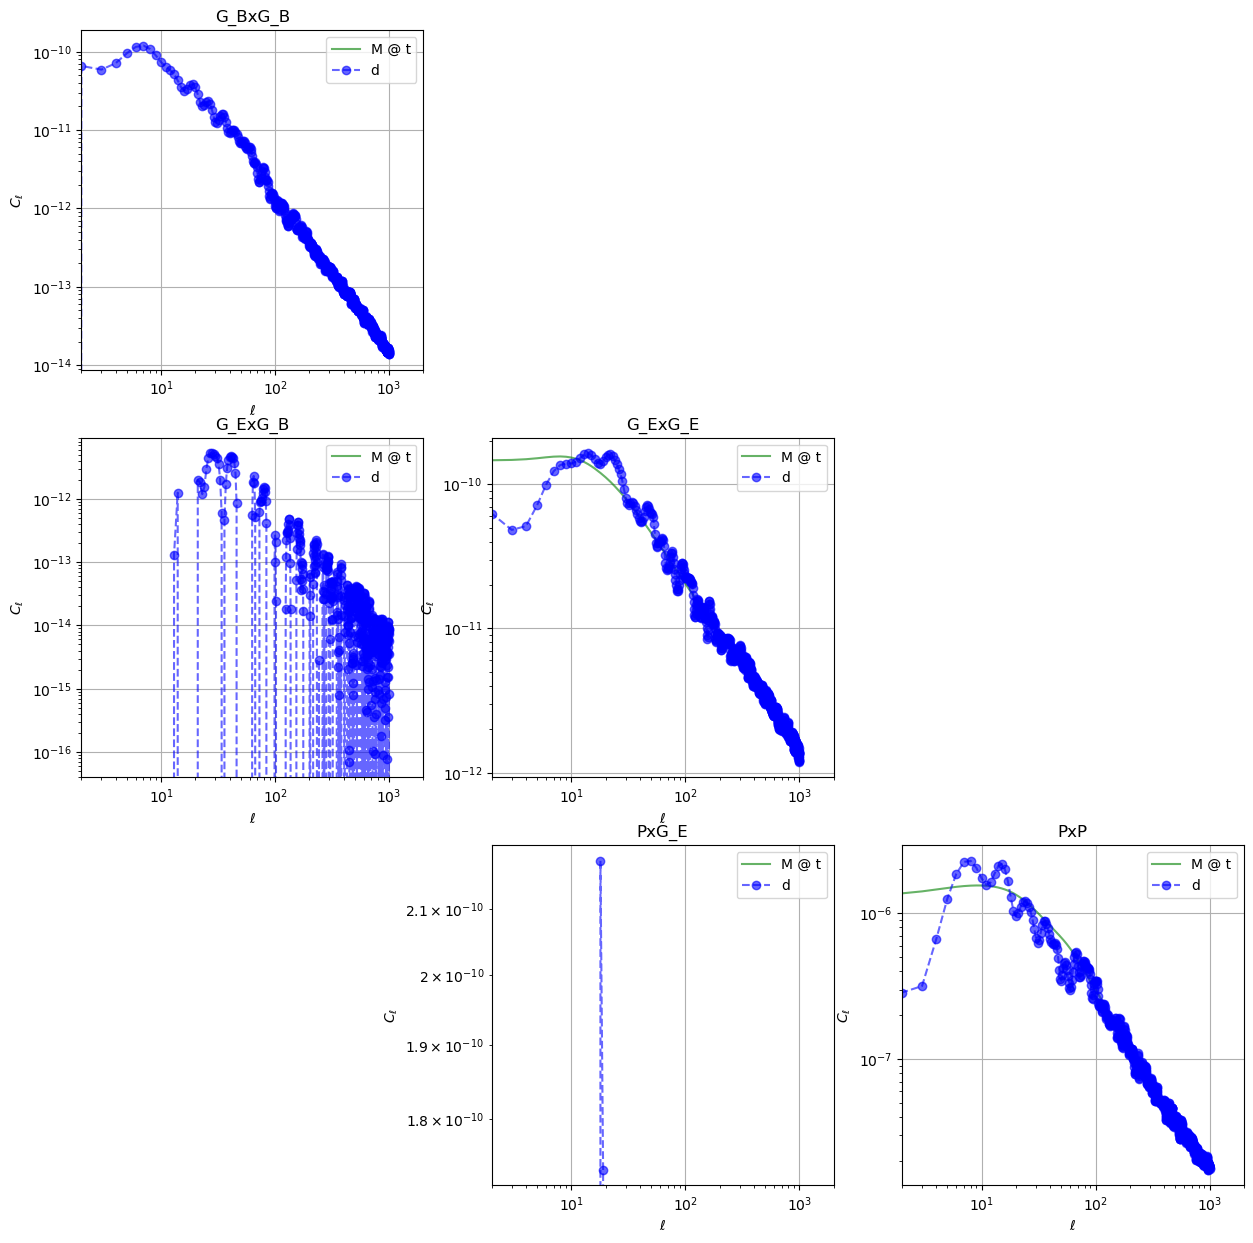

In [23]:
figure, axis = plt.subplots(3, 3, figsize=(5*3, 5*3))
for i, s1 in enumerate(fields_a):
    for j, s2 in enumerate(fields_b):
        proposed_key = (s1, s2, 0, 0)
        if proposed_key in list(mms.keys()):
            print(proposed_key, f"{translator[s1]}x{translator[s2]}") 
            M = mms[proposed_key]
            if s1 == "G_B" or s2 == "G_B":
                t = np.zeros(2*lmax+1)
            else:
                t = theory_cls[f"{translator[s1]}x{translator[s2]}"]
            d = cls[proposed_key]

            axis[i, j].plot(M @ t, 'g-', alpha=0.6, label="M @ t")
            axis[i, j].plot(d, 'bo--', alpha=0.6, label="d")
            axis[i, j].set_xscale('log')
            axis[i, j].set_yscale('log')
            axis[i, j].set_title(f"{s1}x{s2}")
            axis[i, j].set_xlabel(r"$\ell$")
            axis[i, j].set_ylabel(r"$C_\ell$")
            axis[i, j].grid()
            axis[i, j].set_xlim(2, 2*lmax)
            axis[i, j].legend()
        else:
            axis[i, j].axis('off')
plt.show()

('G_B', 'G_B', 0, 0) W2xW2
('G_E', 'G_B', 0, 0) W2xW2
('G_E', 'G_E', 0, 0) W2xW2
('P', 'G_E', 0, 0) W1xW2
('P', 'P', 0, 0) W1xW1


/tmp/ipykernel_21428/4272753184.py:17: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axis[i, j].set_yscale('log')


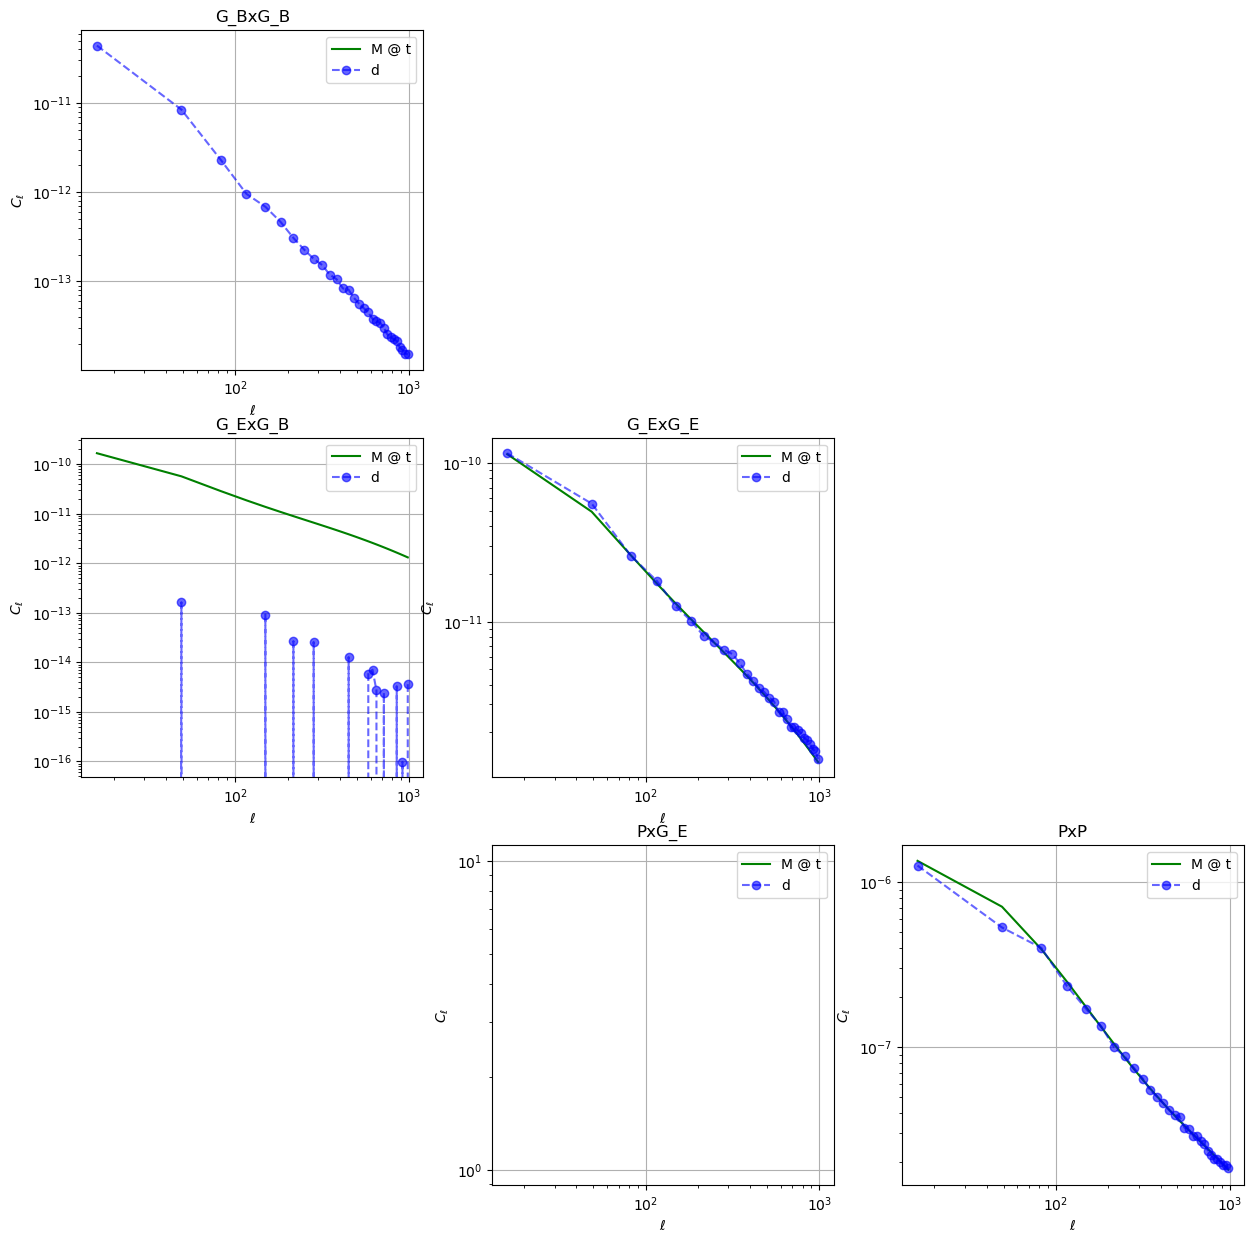

In [24]:
figure, axis = plt.subplots(3, 3, figsize=(5*3, 5*3))
for i, s1 in enumerate(fields_a):
    for j, s2 in enumerate(fields_b):
        proposed_key = (s1, s2, 0, 0)
        if proposed_key in list(mms.keys()):
            print(proposed_key, f"{translator[s1]}x{translator[s2]}") 
            M = mms[proposed_key]
            if s1 == "G_B" and s2 == "G_B":
                t = np.zeros(2*lmax+1)
            else:
                t = theory_cls[f"{translator[s1]}x{translator[s2]}"]
            d = cls[proposed_key]

            axis[i, j].plot(B2 @ l, B @ M @ t, 'g-', label="M @ t")
            axis[i, j].plot(B2 @ l, B @ d, 'bo--', alpha=0.6, label="d")
            axis[i, j].set_xscale('log')
            axis[i, j].set_yscale('log')
            axis[i, j].set_title(f"{s1}x{s2}")
            axis[i, j].set_xlabel(r"$\ell$")
            axis[i, j].set_ylabel(r"$C_\ell$")
            axis[i, j].grid()
            axis[i, j].legend()
        else:
            axis[i, j].axis('off')
plt.show()

## Direct Inversion

|('P', 'P', 0, 0)   ('P', 'G_E', 0, 0)                       |   |'PxP'  |
|('P', 'G_E', 0, 0) ('G_E', 'G_E', 0, 0) ('G_E', 'G_B', 0, 0)| X |'W1xW1'|
|                   ('G_E', 'G_B', 0, 0) ('G_B', 'G_B', 0, 0)|   |'W2xW2'|

In [25]:
list(mms.keys())

[('P', 'P', 0, 0),
 ('P', 'G_E', 0, 0),
 ('G_E', 'G_E', 0, 0),
 ('G_B', 'G_B', 0, 0),
 ('G_E', 'G_B', 0, 0)]

In [26]:
cls_EE_BB = np.append(cls[('G_E', 'G_E', 0, 0)], cls[('G_B', 'G_B', 0, 0)])
print(cls_EE_BB.shape)

M_EE = np.hstack([mms[('G_E', 'G_E', 0, 0)], mms[('G_E', 'G_B', 0, 0)]])
M_BB = np.hstack([mms[('G_E', 'G_B', 0, 0)], mms[('G_B', 'G_B', 0, 0)]])
M_EE_BB = np.vstack([M_EE, M_BB])
print(M_EE_BB.shape)

inv_M_EE_BB = np.linalg.pinv(M_EE_BB)

(2002,)
(2002, 4002)


In [27]:
cls_EE_BB = inv_M_EE_BB @ cls_EE_BB
data_cls = {}
data_cls[('G_E', 'G_E', 0, 0)] = cls_EE_BB[2*lmax+1:]
data_cls[('G_B', 'G_B', 0, 0)] = cls_EE_BB[:2*lmax+1]
data_cls[('G_E', 'G_B', 0, 0)] = np.linalg.pinv(mms[('G_E', 'G_B', 0, 0)]) @ cls[('G_E', 'G_B', 0, 0)]
data_cls[('P', 'G_E', 0, 0)]   = np.linalg.pinv(mms[('P', 'G_E', 0, 0)]) @ cls[('P', 'G_E', 0, 0)]
data_cls[('P', 'P', 0, 0)]     = np.linalg.pinv(mms[('P', 'P', 0, 0)]) @ cls[('P', 'P', 0, 0)]

In [30]:
cls[('P', 'P', 0, 0)].shape

(1001,)

('G_B', 'G_B', 0, 0) W2xW2
('G_E', 'G_B', 0, 0) W2xW2
('G_E', 'G_E', 0, 0) W2xW2
('P', 'G_E', 0, 0) W1xW2
('P', 'P', 0, 0) W1xW1


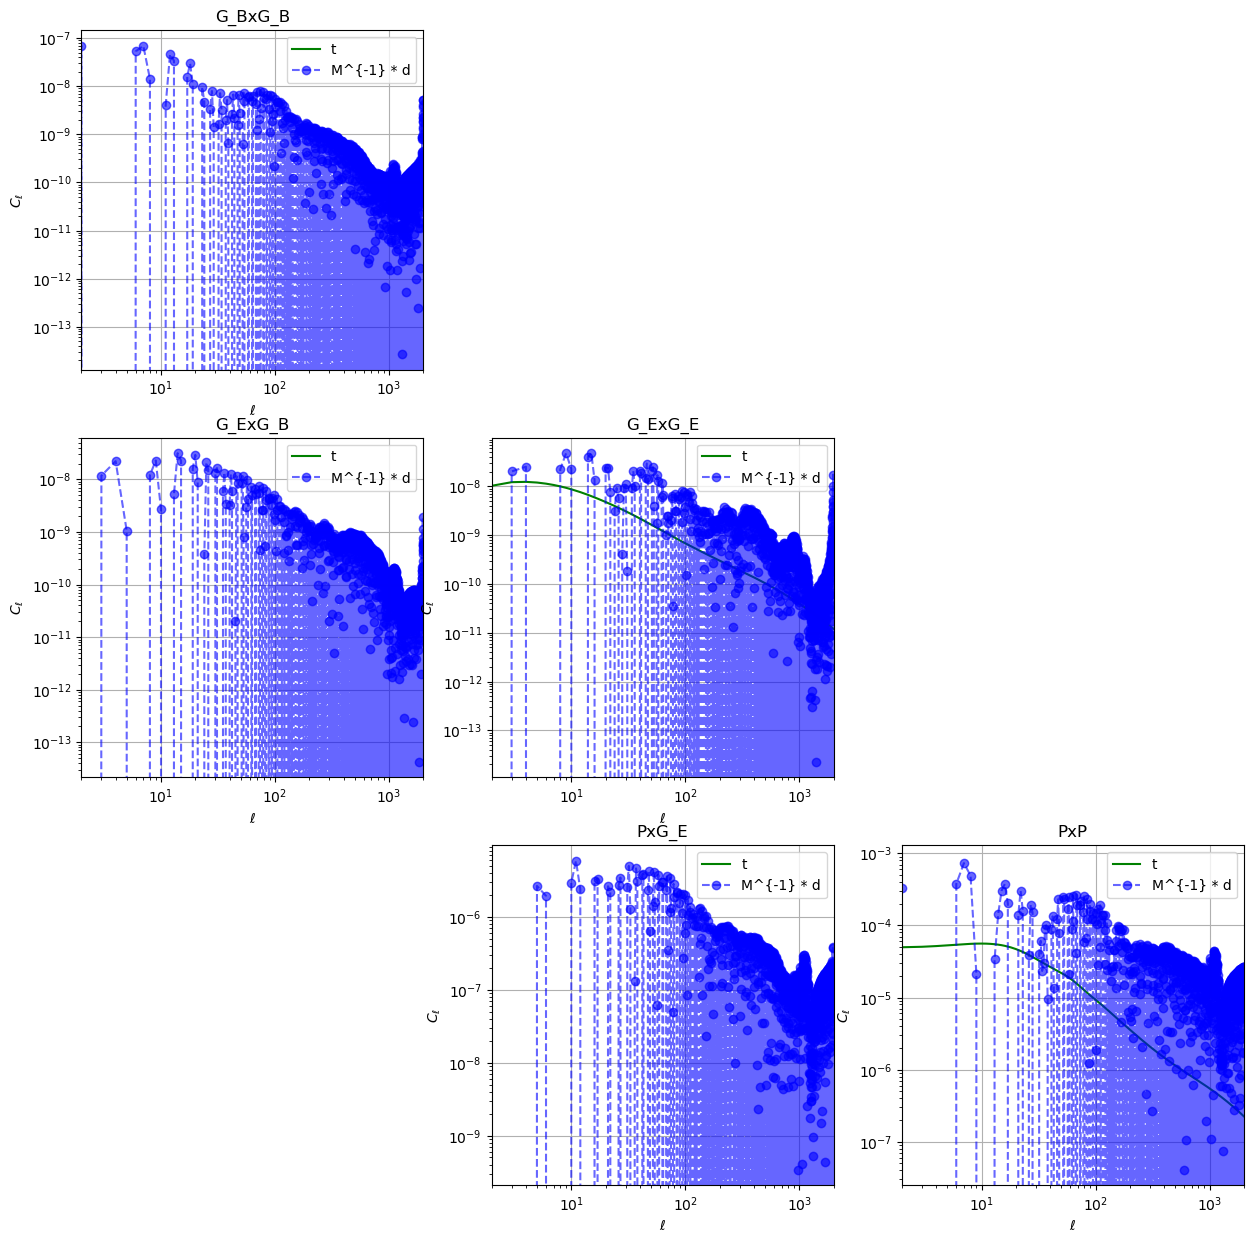

In [28]:
figure, axis = plt.subplots(3, 3, figsize=(5*3, 5*3))
for i, s1 in enumerate(fields_a):
    for j, s2 in enumerate(fields_b):
        proposed_key = (s1, s2, 0, 0)
        if proposed_key in list(mms.keys()):
            print(proposed_key, f"{translator[s1]}x{translator[s2]}") 
            if s1 == "G_B" or s2 == "G_B":
                t = np.zeros(2*lmax+1)
            else:
                t = theory_cls[f"{translator[s1]}x{translator[s2]}"]
            d = data_cls[proposed_key]
            axis[i, j].plot(t, 'g-', label="t")
            axis[i, j].plot(d, 'bo--', alpha=0.6, label="M^{-1} * d")
            axis[i, j].set_xscale('log')
            axis[i, j].set_yscale('log')
            axis[i, j].set_title(f"{s1}x{s2}")
            axis[i, j].set_xlabel(r"$\ell$")
            axis[i, j].set_ylabel(r"$C_\ell$")
            axis[i, j].grid()
            axis[i, j].set_xlim(2, 2*lmax)
            axis[i, j].legend()
            
        else:
            axis[i, j].axis('off')
plt.show()

('G_B', 'G_B', 0, 0) W2xW2
('G_E', 'G_B', 0, 0) W2xW2
('G_E', 'G_E', 0, 0) W2xW2
('P', 'G_E', 0, 0) W1xW2
('P', 'P', 0, 0) W1xW1


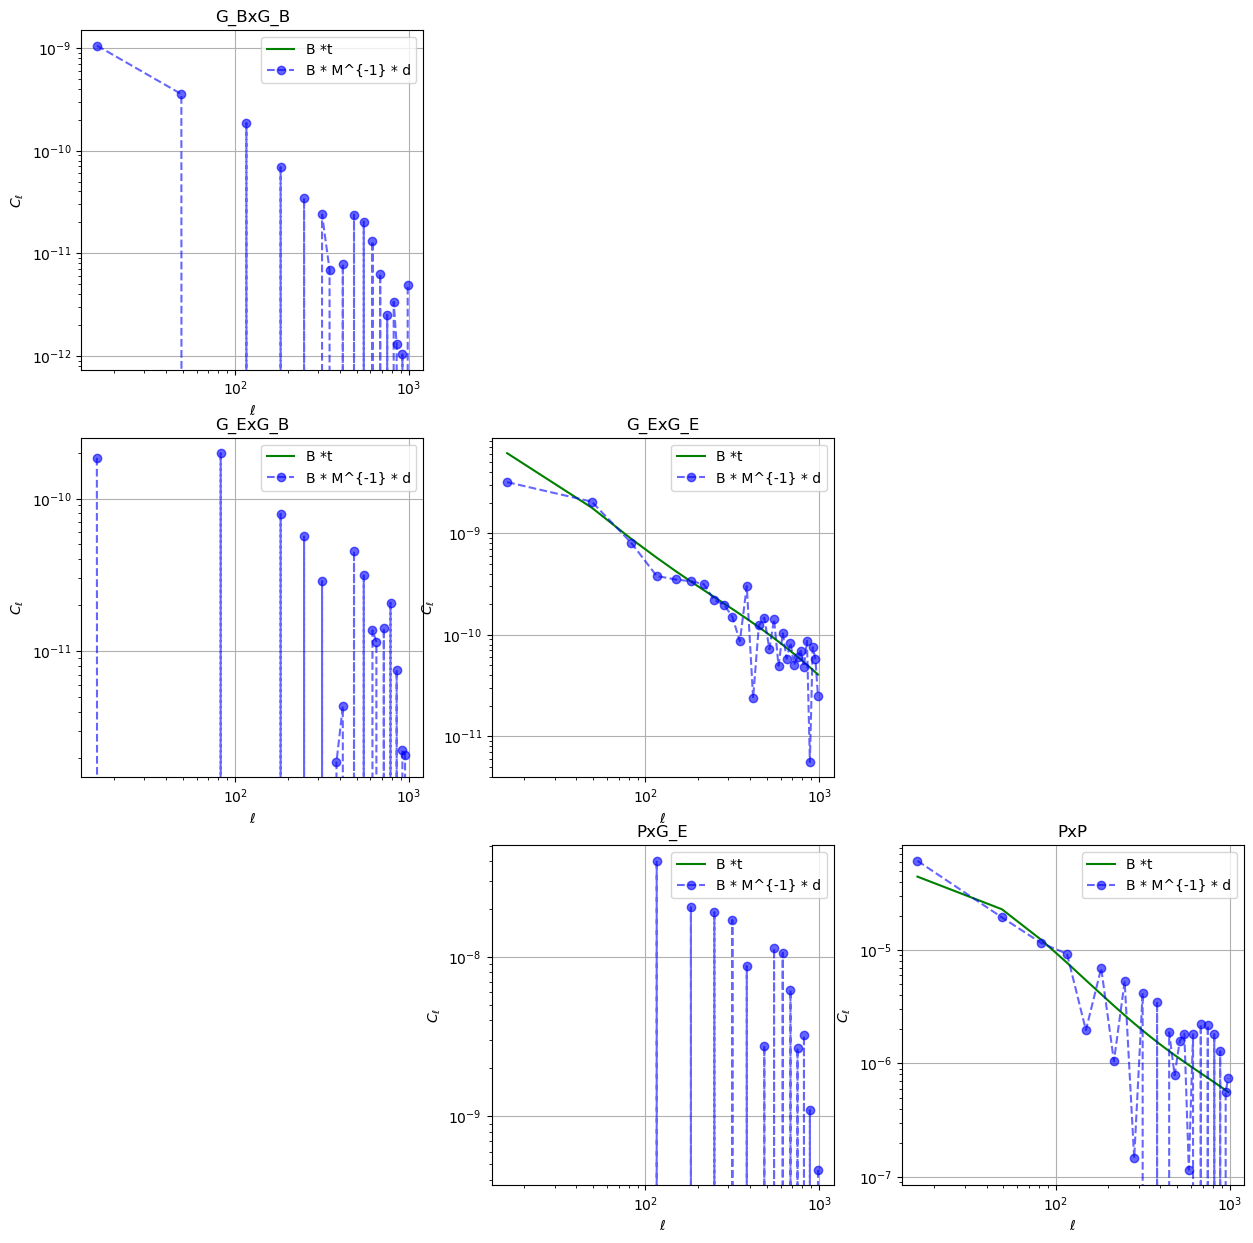

In [29]:
figure, axis = plt.subplots(3, 3, figsize=(5*3, 5*3))
for i, s1 in enumerate(fields_a):
    for j, s2 in enumerate(fields_b):
        proposed_key = (s1, s2, 0, 0)
        if proposed_key in list(mms.keys()):
            print(proposed_key, f"{translator[s1]}x{translator[s2]}") 
            if s1 == "G_B" or s2 == "G_B":
                t = np.zeros(2*lmax+1)
            else:
                t = theory_cls[f"{translator[s1]}x{translator[s2]}"]
            d = data_cls[proposed_key]
            axis[i, j].plot(B2 @ l, B2 @ t, 'g-', label="B *t")
            axis[i, j].plot(B2 @ l, B2 @ d, 'bo--', alpha=0.6, label="B * M^{-1} * d")
            axis[i, j].set_xscale('log')
            axis[i, j].set_yscale('log')
            axis[i, j].set_title(f"{s1}x{s2}")
            axis[i, j].set_xlabel(r"$\ell$")
            axis[i, j].set_ylabel(r"$C_\ell$")
            axis[i, j].grid()
            axis[i, j].legend()
        else:
            axis[i, j].axis('off')
plt.show()